### Empirical Model
How can we apply an empirical model to increase the performance of the model?


### Antoine Equation
$$
ln(P^{*}) = A-\frac{B}{T+C}
$$

We need to remove the column in the dataset, which contains the Vapor Pressure measurements

In [77]:
import pandas as pd
import torch
import numpy as np

data = pd.read_csv('distillation-tower.csv')

X = data.drop('VapourPressure', axis=1)
X = X.iloc[:, 1:]
y = data['VapourPressure']

Now, we need to develop our empirical model by regressing ln(P) vs 1/T.

In [78]:
invt = data['InvTemp3']
vp = data['VapourPressure']

In [79]:
vp = np.log(vp)

In [80]:
from sklearn.linear_model import LinearRegression

invt = np.array(invt).reshape(-1, 1)
vp = np.array(vp)

model = LinearRegression()

model.fit(invt, vp)

vp_pred = model.predict(invt)
X['Antoine'] = vp_pred

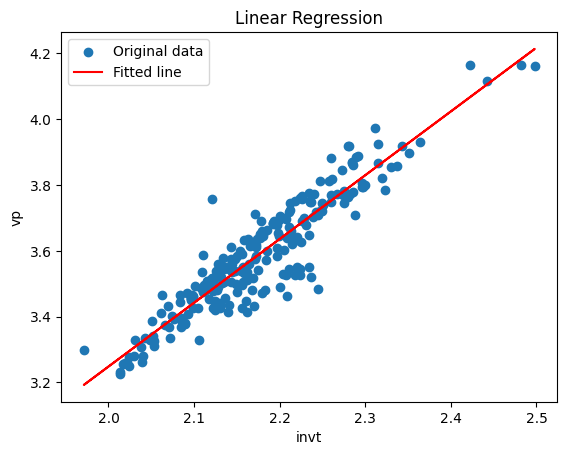

R-squared: 0.8649881279307753


In [81]:
import matplotlib.pyplot as plt

plt.scatter(invt, vp, label='Original data')

# Plotting the regression line
plt.plot(invt, vp_pred, color='red', label='Fitted line')

plt.xlabel('invt')
plt.ylabel('vp')
plt.title('Linear Regression')
plt.legend()

plt.show()

# If you want to evaluate the model you can use metrics like R-squared
r_squared = model.score(invt, vp)
print(f'R-squared: {r_squared}')

From our graph, we can see that the regression model is pretty good at fitting the data.
Now we can use the model to predict the vapor pressure and use this in our neural network.
The goal is for the neural network to use our pressure as a starting point.

In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
from torch.utils.data import TensorDataset, DataLoader

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [84]:
import torch.nn as nn

class VaporPressureNet(nn.Module):
    def __init__(self):
        super(VaporPressureNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 64) 
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1) 

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [85]:
model = VaporPressureNet()

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 3000

for epoch in range(epochs):
    model.train() 
    running_loss = 0.0
    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataloader.dataset)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

model.eval() 
with torch.no_grad(): 
    predictions = []
    targets = []
    for inputs, true_values in test_dataloader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        targets.extend(true_values.tolist())

from sklearn.metrics import r2_score

r2 = r2_score(targets, predictions)
print(f'R^2 Score on test set: {r2:.4f}')

Epoch 1/3000, Loss: 167.8185
Epoch 2/3000, Loss: 116.1629
Epoch 3/3000, Loss: 92.2995
Epoch 4/3000, Loss: 75.1197
Epoch 5/3000, Loss: 71.9072
Epoch 6/3000, Loss: 71.4274
Epoch 7/3000, Loss: 70.8683
Epoch 8/3000, Loss: 70.0098
Epoch 9/3000, Loss: 72.0433
Epoch 10/3000, Loss: 83.5836
Epoch 11/3000, Loss: 71.6840
Epoch 12/3000, Loss: 78.2268
Epoch 13/3000, Loss: 65.0232
Epoch 14/3000, Loss: 66.6030
Epoch 15/3000, Loss: 64.2140
Epoch 16/3000, Loss: 64.7106
Epoch 17/3000, Loss: 68.5630
Epoch 18/3000, Loss: 60.9952
Epoch 19/3000, Loss: 64.5319
Epoch 20/3000, Loss: 67.6398
Epoch 21/3000, Loss: 70.5966
Epoch 22/3000, Loss: 60.6512
Epoch 23/3000, Loss: 57.9553
Epoch 24/3000, Loss: 58.6435
Epoch 25/3000, Loss: 58.6770
Epoch 26/3000, Loss: 62.3550
Epoch 27/3000, Loss: 55.4044
Epoch 28/3000, Loss: 54.4299
Epoch 29/3000, Loss: 49.8449
Epoch 30/3000, Loss: 52.4191
Epoch 31/3000, Loss: 57.3606
Epoch 32/3000, Loss: 60.9491
Epoch 33/3000, Loss: 52.3608
Epoch 34/3000, Loss: 52.5880
Epoch 35/3000, Loss: 

In [86]:
def evaluate(n):
    single_observation = X.iloc[n]
    single_observation = single_observation.apply(pd.to_numeric, errors='coerce').fillna(0)
    single_observation_tensor = torch.tensor(single_observation.values, dtype=torch.float32).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        prediction = model(single_observation_tensor)     
    lnp = vp_pred[80]
    print("Predicted Vapour Pressure:", prediction.item())
    print("Experimental Vapour pressure:", y[n])
    print("Antoine Model Prediction:", np.exp(lnp))

In [94]:
evaluate(80)

Predicted Vapour Pressure: 30.302528381347656
27.9127


In [93]:
lnp = vp_pred[80]
print(np.exp(lnp))

27.365163292066246
